# **ECE324 Final Project - Code**
**Group 3:** Minahil Bakhtawar, Sneha Balaji, and Rachel Chan

**Date:** Friday April 12th, 2024


## Description
Comparing the performance of UNet vs. Res-UNet for lane detection task using the TuSimple dataset. To navigate this notebook easier collapse all unneeded cells with the `˅` arrows.

**Dataset**
* To run the notebook first download the dataset from Kaggle here: [dataset download link](https://www.kaggle.com/code/hikmatullahmohammadi/road-lane-line-tusimple-dataset-preparation/output).
* Upload the file `training.zip` to your drive, altering the string in `cell 4` if necessary to match the actual data path in your Drive.

**How to Train**
* Training was done using the V100 GPU with High RAM, consuming approximately 5 compute units per hour.
  * Less powerful GPUs are not recommended as it could take several hours to train the models rather than a few minutes.

# **SETUP**


## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
import cv2
import os
import gc
import h5py
import math
import scipy.misc
from IPython.display import SVG

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, Sequential

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, UpSampling2D, Concatenate, Dropout, ReLU, Conv2DTranspose, LeakyReLU
from keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.applications import ResNet50

%matplotlib inline
import tensorflow.keras.backend as K
# Image dataset has channels as its last dimensions
K.set_image_data_format('channels_last')

## Unzip Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/MyDrive/training.zip'

## ***Helper Functions***




**Data Functions:**
1. `load_images_and_masks(images_dir, masks_dir, target_size=(256, 320))`
  * Returns X=images and Y=masks from TuSimple dataset
2. `preprocess_and_split_data(X, Y, num_samples=2000, test_size=0.1, rand_state=100)`
  * Returns X_train, X_val, Y_train, Y_val. Shuffles data, normalizes masks, cuts off data after num_samples, then splits it into training and validation sets.

**Plotting Functions:**
1.   `display_training_images(X_samples, Y_samples, num_plots, fig_size=(8,8))`
  *  Plots all training images in X_samples & Y_samples
2.   `display_predictions(X_val_samples, Y_pred_samples, Y_val_samples, num_plots, fig_size = (10, 45), save_plots=True)`
  * Plots original, truth, and prediction samples and save images if save_plots = True
3. `compare_predictions(X_val_samples, UNet_pred_samples, ResUNet_pred_samples, Y_val_samples, num_plots, fig_size = (12, 45), save_plots=True)`
  * Plots original, truth, and prediction samples for both UNet and ResUNet, saves images if save_plots = True

**Performance Functions:**
1.   `performance_metrics(Y_true, Y_pred, num_classes=2, target_class_ids = [1], display=True)`
  * Returns accuracy, precision, recall, f1 score, and iou scores using Y_true and Y_pred. Prints results for each if display=True.

### Data processing

In [ ]:
# DATA FUNCTIONS
# loads the images and their corresponding masks from the dataset and returns them in numpy arrays.
def load_images_and_masks(images_dir, masks_dir, target_size=(256, 320)):
    print("\nLoading images and masks...")
    image_filenames = sorted(os.listdir(images_dir))
    mask_filenames = sorted(os.listdir(masks_dir))

    X, Y = [], []
    for img_name, mask_name in zip(image_filenames, mask_filenames):
        img_path = os.path.join(images_dir, img_name)
        mask_path = os.path.join(masks_dir, mask_name)

        img = cv2.imread(img_path)
        img = cv2.resize(img, (target_size[1], target_size[0]))  # Corrected order
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (target_size[1], target_size[0]))  # Corrected order
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension for grayscale mask

        X.append(img)
        Y.append(mask)

    # Print data size
    print(f"Number of images: {len(X)}")
    print(f"Number of masks: {len(Y)}")

    return np.array(X), np.array(Y)

def preprocess_and_split_data(X, Y, num_samples=2000, test_size=0.1, rand_state=100):
    '''
    Returns split shuffled data up to num_samplpes after normalizing Y
    '''
    print("\nProcessing and splitting data...")
    # Preprocess
    X, Y = shuffle(X, Y, random_state=rand_state)               # shuffle
    Y = (Y >= 100).astype('int').reshape(-1, 256, 320, 1)   # normalize masks
    X, Y = np.array(X[:num_samples]), np.array(Y[:num_samples]) # cutoff samples after num_samples

    # Split into train & eval
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=test_size, random_state=rand_state)

    # Print results
    print("Shape of X_train:", X_train.shape)
    print("Shape of X_val:", X_val.shape)
    print("Shape of Y_train:", Y_train.shape)
    print("Shape of Y_val:", Y_val.shape)

    return X_train, X_val, Y_train, Y_val

### Plotting

Helper functions used to display training images in the samples, display predictions and compare the predictions of the 2 models discussed in this project.

In [ ]:
# PLOTTING FUNCTIONS
def display_training_images(X_samples, Y_samples, num_plots, fig_size=(8,8)):
    '''
    Plots all training images in X_samples & Y_samples
    '''
    # Counter
    index = 1

    # Plotting
    plt.figure(figsize=fig_size)
    for orignal_image, target_mask in zip(X_samples, Y_samples):

        plt.subplot(num_plots, 2, index)
        plt.imshow(orignal_image/255.)
        plt.title('Ground truth image')

        plt.subplot(num_plots, 2, index+1)
        plt.imshow(target_mask.squeeze(), cmap='gray')
        plt.title('Target mask')

        index += 2

    plt.tight_layout()
    plt.show()
    return

def display_predictions(X_val_samples, Y_pred_samples, Y_val_samples, num_plots, fig_size = (10, 25), save_plots=True):
    '''
    Plots original, truth, and prediction samples and save images if save_plots = True
    '''
    # Counter
    index = 1

    # Plotting
    plt.figure(figsize=fig_size)
    for original_image, pred_mask, true_mask in zip(X_val_samples, Y_pred_samples, Y_val_samples):
        # Saving plots
        if save_plots:
            cv2.imwrite(f'./out/img-{index}.jpg', original_image)
            cv2.imwrite(f'./out/pred-{index}.jpg', pred_mask*255.)
            cv2.imwrite(f'./out/ground-{index}.jpg', true_mask*255.)

        plt.subplot(num_plots, 3, index)
        plt.imshow(original_image/255.)
        plt.title('Ground truth image')

        plt.subplot(num_plots, 3, index+1)
        plt.imshow(true_mask, cmap='gray')
        plt.title('True mask')

        plt.subplot(num_plots, 3, index+2)
        plt.imshow(pred_mask, cmap='gray')
        plt.title('Pred mask')

        index += 3

    plt.tight_layout()
    plt.show()
    return

def compare_predictions(X_val_samples, UNet_pred_samples, ResUNet_pred_samples, Y_val_samples, num_plots, fig_size = (12, 25), save_plots=True):
    '''
    Plots original, truth, and prediction samples for both UNet and ResUNet, saves images if save_plots = True 
    for comparison.
    '''
    # Counter
    index = 1

    # Plotting
    plt.figure(figsize=fig_size)
    for original_image, UNetpred_mask, ResUNetpred_mask, true_mask in zip(X_val_samples, UNet_pred_samples, ResUNet_pred_samples, Y_val_samples):
        # Saving plots
        if save_plots:
            cv2.imwrite(f'./out/img-{index}.jpg', original_image)
            cv2.imwrite(f'./out/UNetpred-{index}.jpg', UNetpred_mask*255.)
            cv2.imwrite(f'./out/ResUNetpred-{index}.jpg', ResUNetpred_mask*255.)
            cv2.imwrite(f'./out/ground-{index}.jpg', true_mask*255.)

        plt.subplot(num_plots, 4, index)
        plt.imshow(original_image/255.)
        plt.title('Ground truth image')

        plt.subplot(num_plots, 4, index+1)
        plt.imshow(true_mask, cmap='gray')
        plt.title('True mask')

        plt.subplot(num_plots, 4, index+2)
        plt.imshow(UNetpred_mask, cmap='gray')
        plt.title('UNet predicted mask')

        plt.subplot(num_plots, 4, index+3)
        plt.imshow(ResUNetpred_mask, cmap='gray')
        plt.title('ResUNet predicted mask')

        index += 4

    plt.tight_layout()
    plt.show()
    return

### Performance Scores

In [ ]:
# PERFOMANCE SCORES
def performance_metrics(Y_true, Y_pred, num_classes=2, target_class_ids = [1], display=True):
    '''
    Returns accuracy, precision, recall, f1 score, and iou scores using Y_true and Y_pred. Prints 
    results for each if display=True.
    '''
    # Create evaluation objects
    accuracy = tf.keras.metrics.Accuracy()
    precision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()
    iou = tf.keras.metrics.IoU(num_classes=num_classes, target_class_ids=target_class_ids)

    # Accuracy
    accuracy.update_state(Y_true, Y_pred)
    accuracy_value = accuracy.result().numpy()

    # Precision
    precision.update_state(Y_true, Y_pred)
    precision_value = precision.result().numpy()

    # Recall
    recall.update_state(Y_true, Y_pred)
    recall_value = recall.result().numpy()

    # F1 score
    f1_score = 2 / ((1 / precision_value) + (1 / recall_value))

    # Intersection over union (IoU)
    iou.update_state(Y_true, Y_pred)
    iou_value = iou.result().numpy()

    # Print results
    if display:
      print(f"Accuracy:  {accuracy_value}")
      print(f"Precision: {precision_value}")
      print(f"Recall:    {recall_value}")
      print(f"F1 Score:  {f1_score}")
      print(f"IoU:       {iou_value}")

    return accuracy_value, precision_value, recall_value, f1_score, iou_value

# **MODELS**

This section specifies the model architectures for the UNet and the ResUNet.

## ***UNet***

In [ ]:
# UNET MODEL
def unet(input_size=(256,320,3)):
    inputs = Input(input_size)
    rescale = keras.layers.Rescaling(1./255)(inputs)
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(rescale)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bridge
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop5))
    merge6 = Concatenate(axis=3)([conv4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs, name="UNet")

    return model

## ***Res-UNet***

In [ ]:
# Decoder block
def decoder_block(x, y, filters):
  x = UpSampling2D()(x)
  x = Concatenate(axis=3)([x,y])
  x = Conv2D(filters, 3, padding='same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)

  x = Conv2D(filters, 3, padding='same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)

  return x

# ResNet50
def ResUNet50(input_shape=(256,320,3)):
  # format inputs
  inputs = Input(input_shape)
  rescale = keras.layers.Rescaling(1./255)(inputs)

  # Get ResNet50 (not pre-trained)
  resnet50 = ResNet50(include_top=False, input_tensor=inputs)

  # Encoder
  c1 = resnet50.input
  c2 = resnet50.get_layer('conv1_relu').output
  c3 = resnet50.get_layer('conv2_block3_out').output
  c4 = resnet50.get_layer('conv3_block4_out').output

  # Bridge
  b1 = resnet50.get_layer('conv4_block6_out').output

  # Decoder
  d1 = decoder_block(b1, c4, 512)
  d2 = decoder_block(d1, c3, 256)
  d3 = decoder_block(d2, c2, 128)
  d4 = decoder_block(d3, c1, 64)

  # Output
  outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(d4)

  model = Model(inputs=inputs, outputs=outputs, name='ResUNet50')
  return model


# **EXPERIMENTS**

### Parameters

Declaring parameters for the training. This includes epochs, batch size, paths, shapes of input arrays.

In [ ]:
# Global
input_shape = (256, 320, 3)
rand_state = 100    # random state
N = 2000            # num total samples

# Data
images_path = '/content/kaggle/working/tusimple_preprocessed/training/frames'
masks_path = '/content/kaggle/working/tusimple_preprocessed/training/lane-masks'

# Training
epochs = 15         # num training epochs
batch_size = 8      # batch size

# Display
train_samples = (80, 84)    # training samples to plot
pred_samples = (90, 98)     # prediction samples to plot
train_fig_size = (8, 8)     # for training plots

### Loading and processing data

In [ ]:
# Retrive data
X, Y = load_images_and_masks(images_path, masks_path)
X_train, X_val_test, Y_train, Y_val_test = preprocess_and_split_data(X, Y, num_samples=N, test_size=0.2, rand_state=rand_state)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=0.5, random_state=rand_state)
del X, Y # free RAM
gc.collect()


Loading images and masks...
Number of images: 3626
Number of masks: 3626

Processing and splitting data...
Shape of X_train: (1600, 256, 320, 3)
Shape of X_val: (400, 256, 320, 3)
Shape of Y_train: (1600, 256, 320, 1)
Shape of Y_val: (400, 256, 320, 1)


70819

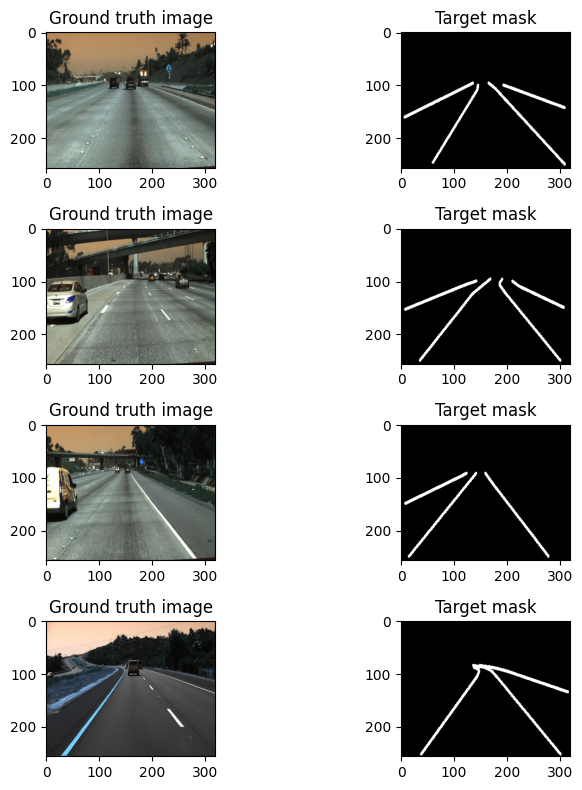

In [ ]:
# Display some training images
display_training_images(X_train[train_samples[0]:train_samples[1]], Y_train[train_samples[0]:train_samples[1]], num_plots=train_samples[1]-train_samples[0], fig_size=train_fig_size)

## ***Running UNet***

### Training

In [ ]:
# Create model
unet_model = unet()
unet_model.compile(optimizer='adam', loss=keras.losses.BinaryFocalCrossentropy(), metrics=['accuracy'])
unet_model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 256, 320, 3)]        0         []                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, 256, 320, 3)          0         ['input_9[0][0]']             
                                                                                                  
 conv2d_119 (Conv2D)         (None, 256, 320, 64)         1792      ['rescaling_7[0][0]']         
                                                                                                  
 conv2d_120 (Conv2D)         (None, 256, 320, 64)         36928     ['conv2d_119[0][0]']          
                                                                                               

In [ ]:
# Training
callbacksUNet = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

historyUNet = unet_model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    callbacks=callbacksUNet,
    validation_data=(X_val, Y_val),
    batch_size=batch_size
)

Epoch 1/15
200/200 [==============================] - ETA: 0s - loss: 0.2474 - accuracy: 0.9529

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 53s 231ms/step - loss: 0.2474 - accuracy: 0.9529 - val_loss: 0.0283 - val_accuracy: 0.9619
Epoch 2/15
200/200 [==============================] - 46s 230ms/step - loss: 0.0222 - accuracy: 0.9676 - val_loss: 0.0176 - val_accuracy: 0.9731
Epoch 3/15
200/200 [==============================] - 46s 229ms/step - loss: 0.0166 - accuracy: 0.9743 - val_loss: 0.0154 - val_accuracy: 0.9759
Epoch 4/15
200/200 [==============================] - 46s 229ms/step - loss: 0.0149 - accuracy: 0.9764 - val_loss: 0.0147 - val_accuracy: 0.9770
Epoch 5/15
200/200 [==============================] - 46s 229ms/step - loss: 0.0138 - accuracy: 0.9778 - val_loss: 0.0135 - val_accuracy: 0.9784
Epoch 6/15
200/200 [==============================] - 46s 229ms/step - loss: 0.0130 - accuracy: 0.9789 - val_loss: 0.0135 - val_accuracy: 0.9789
Epoch 7/15
200/200 [==============================] - 46s 228ms/step - loss: 0.0127 - accuracy: 0.9793 - val_loss: 0.0130 - val_accuracy: 0.9

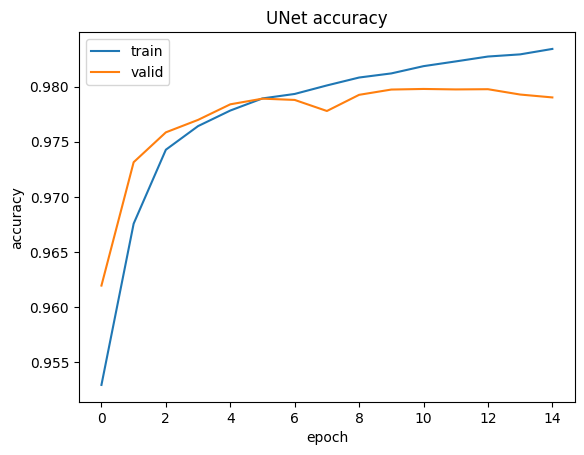

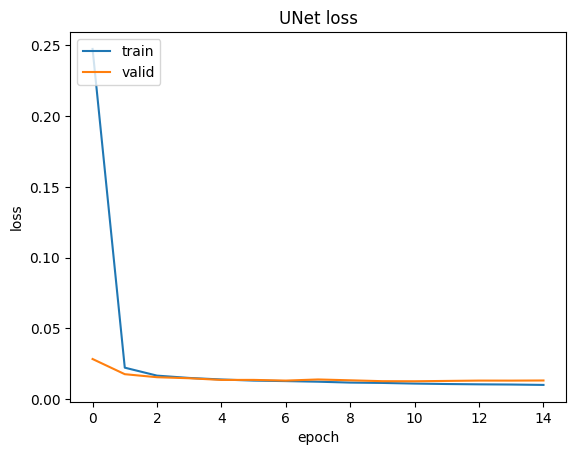

In [ ]:
# Show training curves

# summarize history for accuracy
plt.plot(historyUNet.history['accuracy'])
plt.plot(historyUNet.history['val_accuracy'])
plt.title('UNet accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(historyUNet.history['loss'])
plt.plot(historyUNet.history['val_loss'])
plt.title('UNet loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

### Prediction

In [ ]:
# Prediction
Y_pred_UNet = unet_model.predict(X_test)
Y_pred_UNet = (Y_pred_UNet >= .5).astype('int')

7/7 [==============================] - 1s 198ms/step


Below some of the predictions from UNet are visualized.

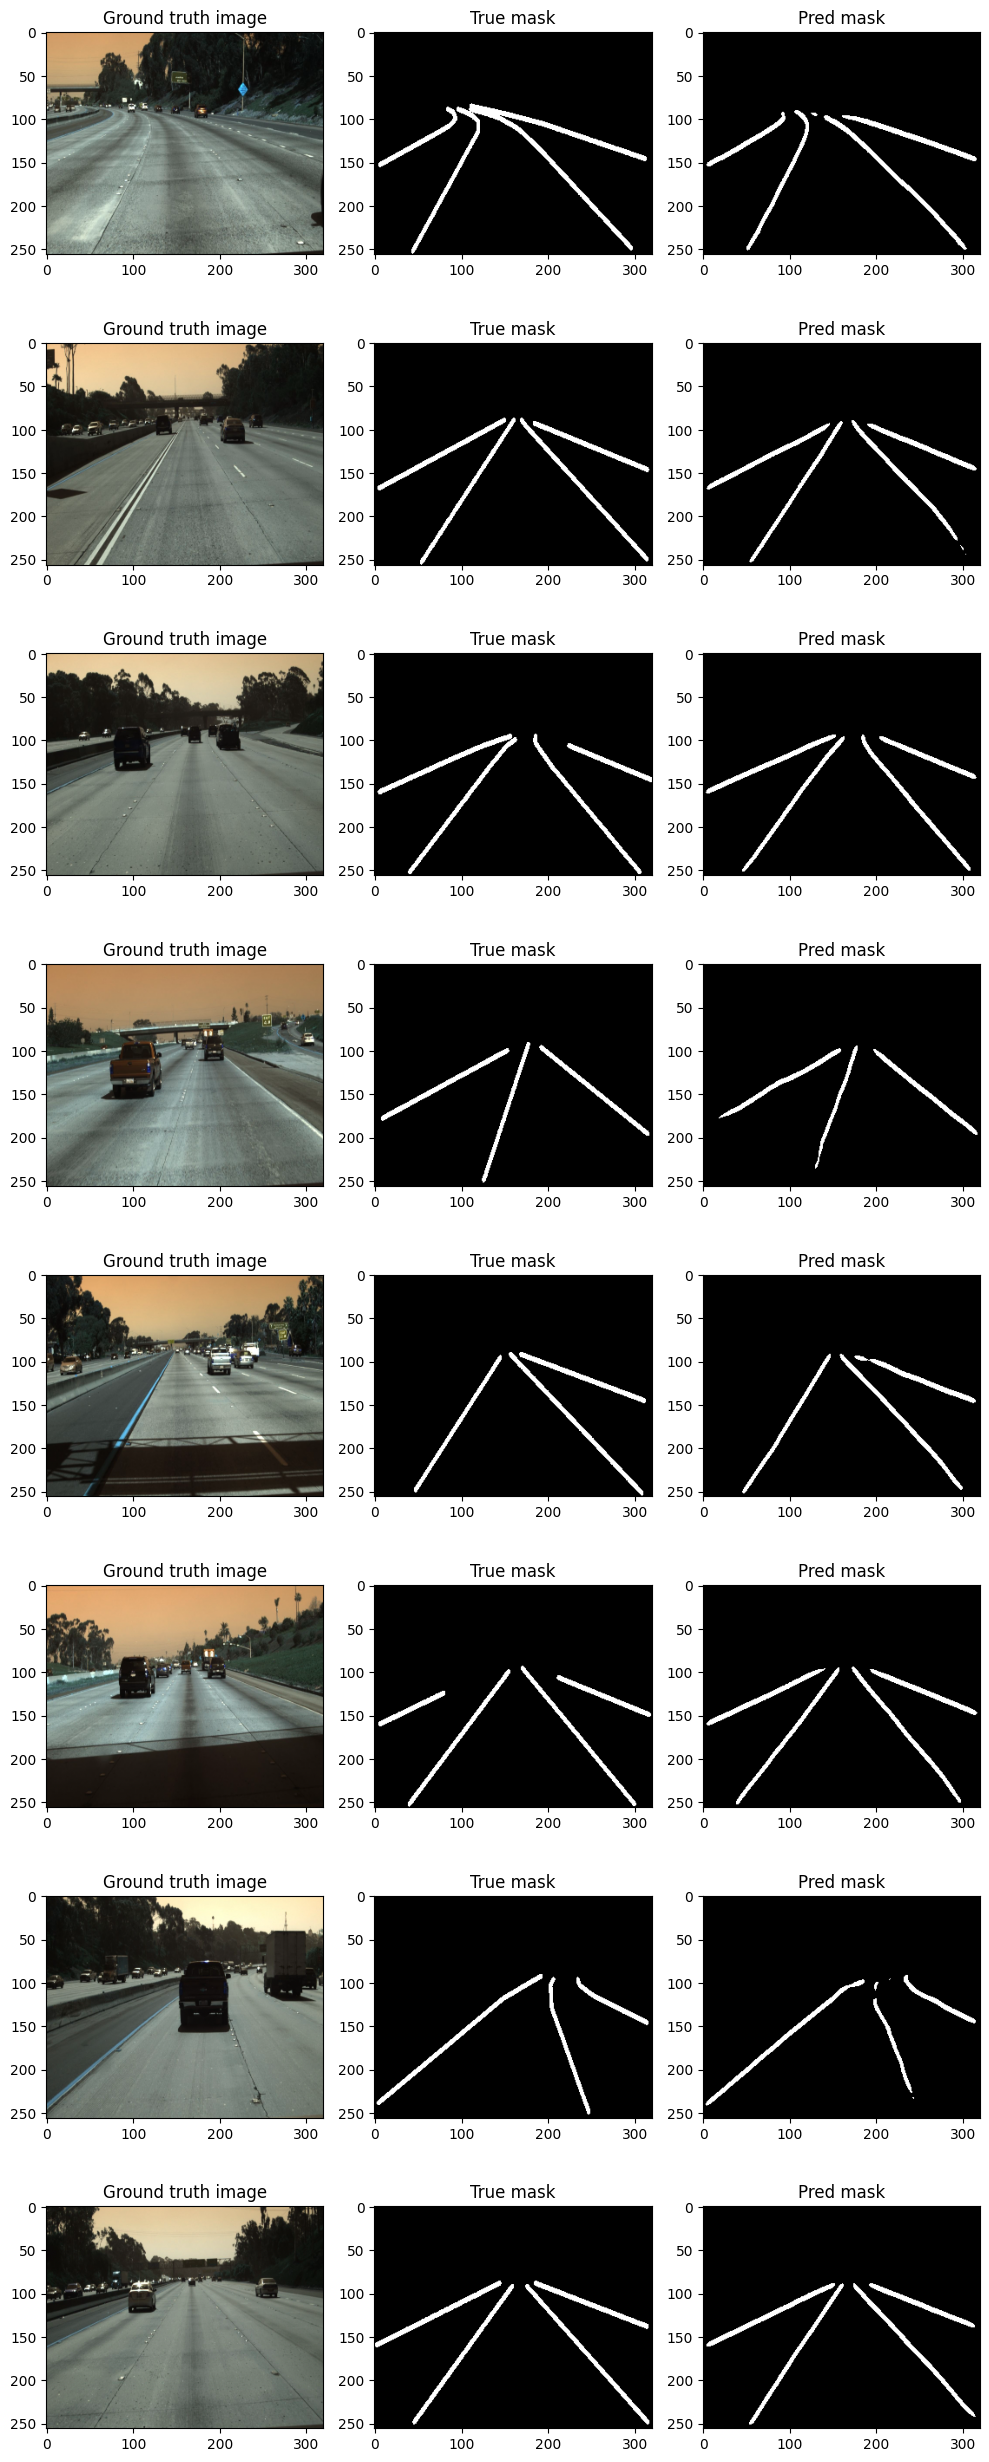

In [ ]:
# Visualize some results from the UNet

# Parameters
pred_fig_size = (10, 25)    # for predictions plots
save_pred_plots = True      # for saving prediction plots

# Get samples to plot
X_samples = X_test[pred_samples[0]:pred_samples[1]]
Y_pred_samples = Y_pred_UNet[pred_samples[0]:pred_samples[1]]
Y_test_samples = Y_test[pred_samples[0]:pred_samples[1]]
num_samples = pred_samples[1]-pred_samples[0]

# Display results
display_predictions(X_samples, Y_pred_samples, Y_test_samples, num_plots=num_samples, fig_size=pred_fig_size, save_plots=save_pred_plots)

### Performance

In [ ]:
# Get performance metrics
accuracy_value, precision_value, recall_value, f1_score, iou_value = performance_metrics(Y_test, Y_pred_UNet)

Accuracy:  0.9786874055862427
Precision: 0.7848350405693054
Recall:    0.7167952656745911
F1 Score:  0.7492736915023758
IoU:       0.5990709066390991


## ***Running Res-UNet***

### Training

In [ ]:
# Create model
resunet_model = ResUNet50()
resunet_model.compile(optimizer='adam', loss=keras.losses.BinaryFocalCrossentropy(), metrics=['accuracy'])
resunet_model.summary()

Model: "ResUNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 256, 320, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 326, 3)          0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 160, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 160, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                      

In [ ]:
# Training
callbacksResUNet = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

historyResUNet = resunet_model.fit(
    X_train,
    Y_train,
    epochs=10,
    callbacks=callbacksResUNet,
    validation_data=(X_val, Y_val),
    batch_size=batch_size
)

Epoch 1/10
200/200 [==============================] - 34s 173ms/step - loss: 0.0075 - accuracy: 0.9875 - val_loss: 0.0215 - val_accuracy: 0.9771
Epoch 2/10
200/200 [==============================] - 34s 171ms/step - loss: 0.0071 - accuracy: 0.9882 - val_loss: 0.0186 - val_accuracy: 0.9785
Epoch 3/10
200/200 [==============================] - 34s 171ms/step - loss: 0.0066 - accuracy: 0.9891 - val_loss: 0.0179 - val_accuracy: 0.9782
Epoch 4/10
200/200 [==============================] - 34s 171ms/step - loss: 0.0063 - accuracy: 0.9896 - val_loss: 0.0185 - val_accuracy: 0.9789
Epoch 5/10
200/200 [==============================] - 34s 171ms/step - loss: 0.0059 - accuracy: 0.9902 - val_loss: 0.0193 - val_accuracy: 0.9784
Epoch 6/10
200/200 [==============================] - 34s 171ms/step - loss: 0.0057 - accuracy: 0.9906 - val_loss: 0.0218 - val_accuracy: 0.9778
Epoch 7/10
200/200 [==============================] - 34s 172ms/step - loss: 0.0055 - accuracy: 0.9909 - val_loss: 0.0248 - val_ac

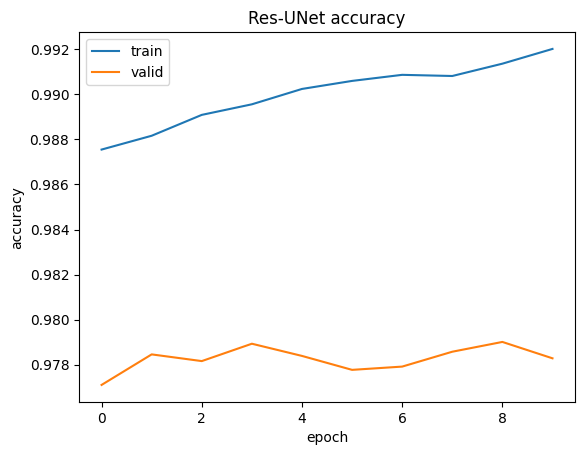

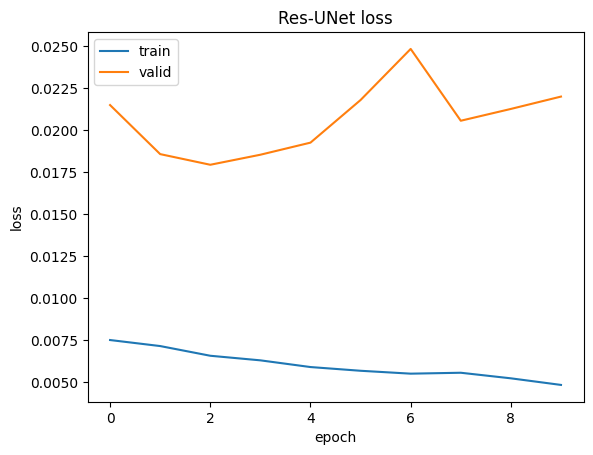

In [ ]:
# Show training curves

# summarize history for accuracy
plt.plot(historyResUNet.history['accuracy'])
plt.plot(historyResUNet.history['val_accuracy'])
plt.title('Res-UNet accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(historyResUNet.history['loss'])
plt.plot(historyResUNet.history['val_loss'])
plt.title('Res-UNet loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

### Prediction

In [ ]:
# Prediction
Y_pred_ResUNet = resunet_model.predict(X_test)
Y_pred_ResUNet = (Y_pred_ResUNet >= .5).astype('int')

7/7 [==============================] - 1s 171ms/step


Below some of the predictions from the ResUNet are visualized.

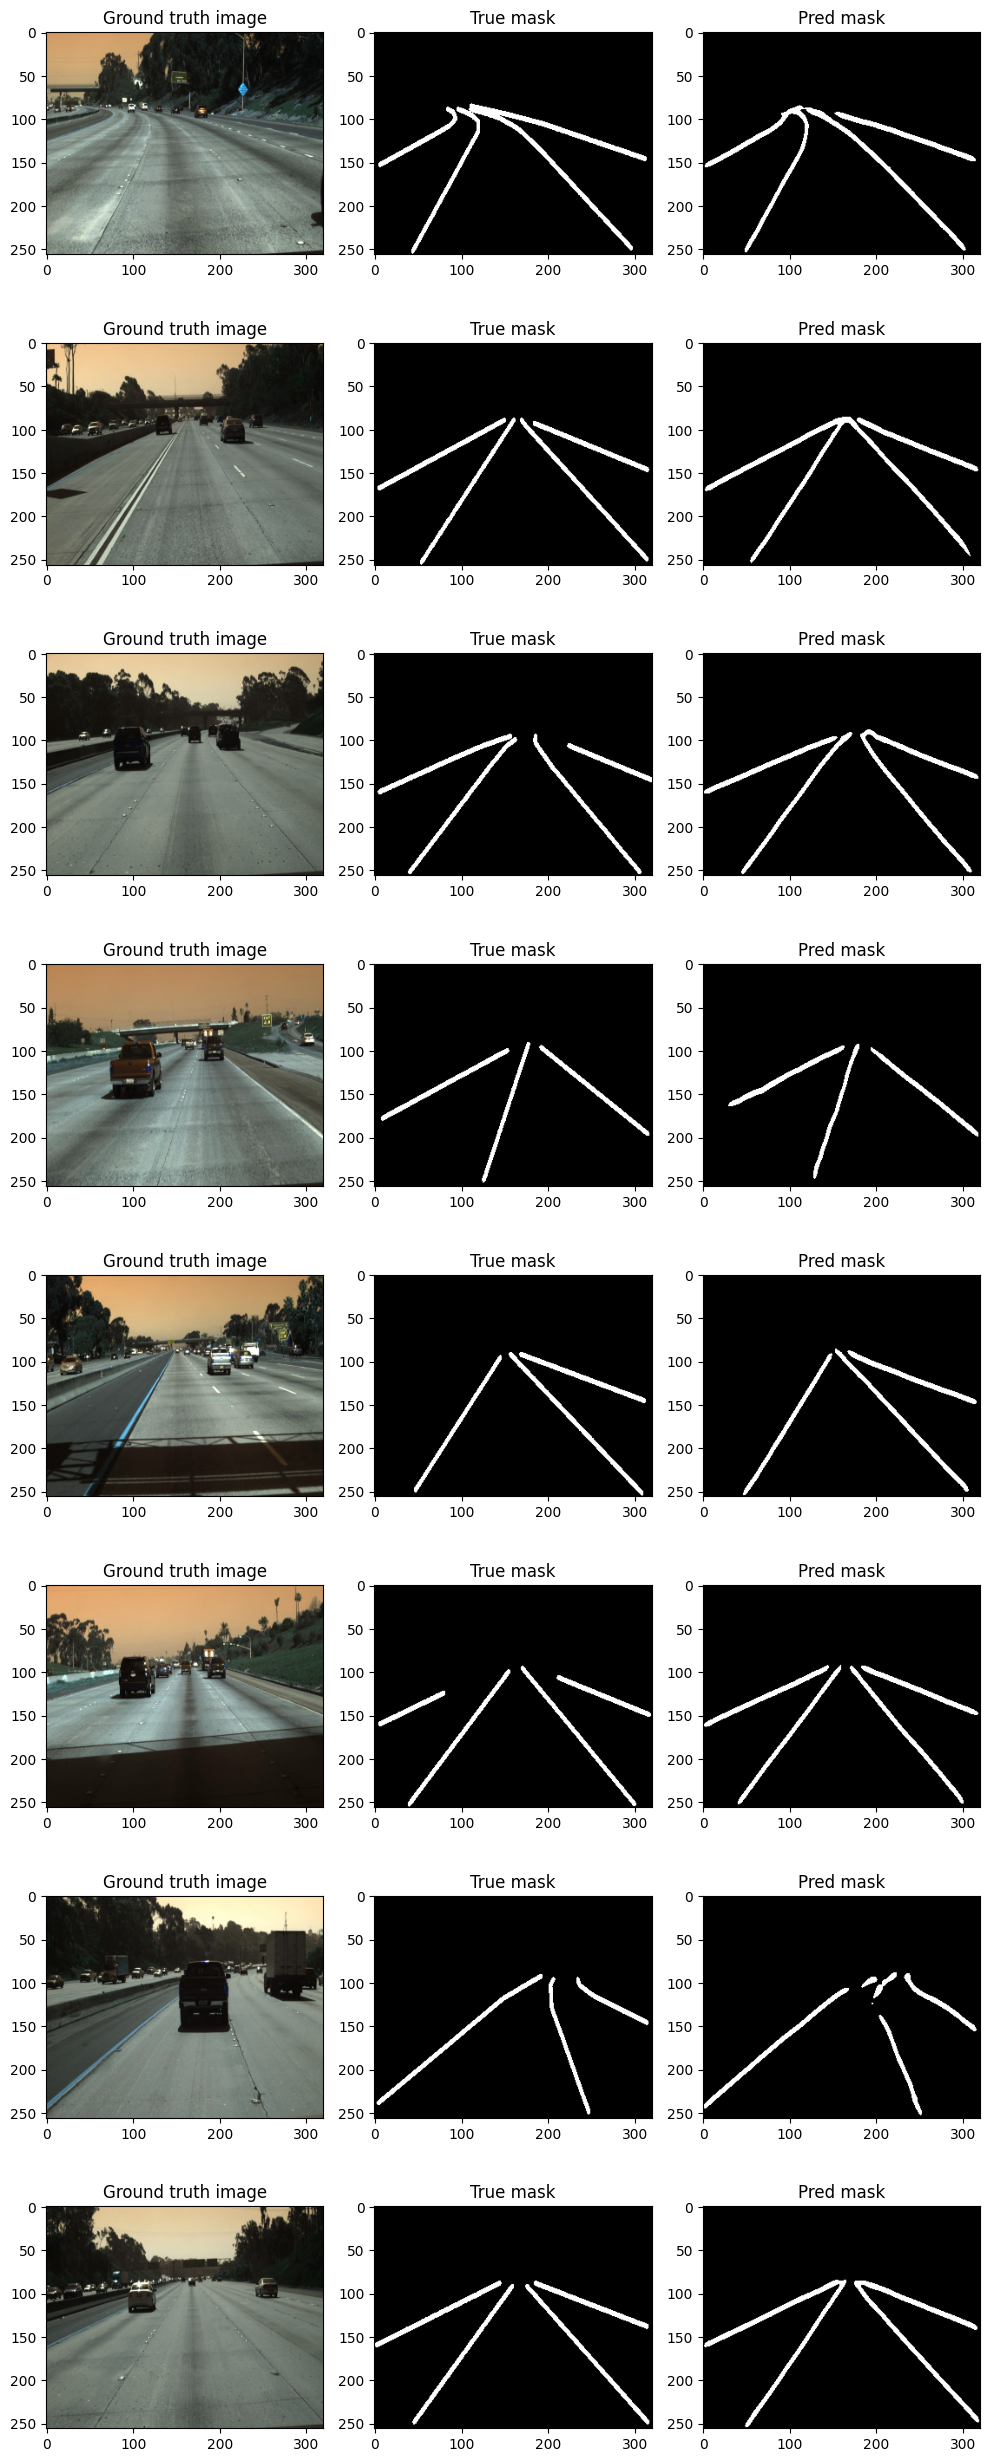

In [ ]:
# Visualize some results

# Parameters
pred_fig_size = (10, 25)    # for predictions plots
save_pred_plots = True      # for saving prediction plots

# Get samples to plot
X_samples = X_test[pred_samples[0]:pred_samples[1]]
Y_pred_samples = Y_pred_ResUNet[pred_samples[0]:pred_samples[1]]
Y_test_samples = Y_test[pred_samples[0]:pred_samples[1]]
num_samples = pred_samples[1]-pred_samples[0]

# Display results
display_predictions(X_samples, Y_pred_samples, Y_test_samples, num_plots=num_samples, fig_size=pred_fig_size, save_plots=save_pred_plots)

### Performance

In [ ]:
# Get performance metrics
accuracy_value, precision_value, recall_value, f1_score, iou_value = performance_metrics(Y_test, Y_pred_ResUNet)

Accuracy:  0.978340744972229
Precision: 0.7582464814186096
Recall:    0.7523577809333801
F1 Score:  0.7552906533871825
IoU:       0.6068008542060852


# **COMPARING RESULTS**

THis section compares the training curves, losses, predictions and performance curves of the 2 models.

## Training Curves

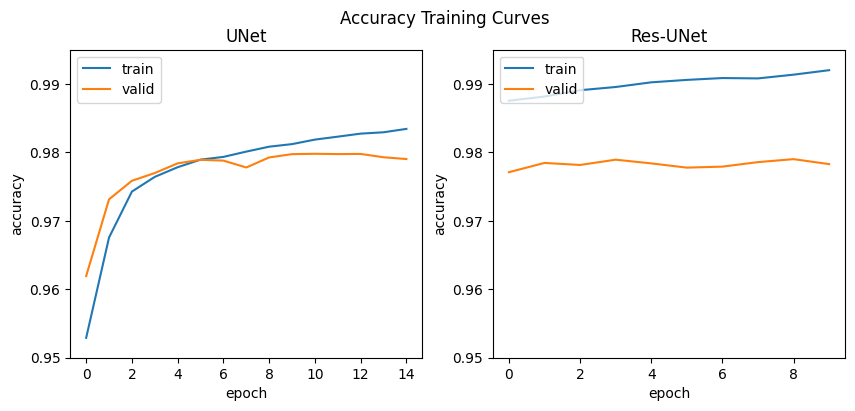

In [121]:
# ACCURACY
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Accuracy Training Curves')

# UNet accuracy history
ax1.plot(historyUNet.history['accuracy'])
ax1.plot(historyUNet.history['val_accuracy'])
ax1.title.set_text('UNet')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylim(0.95, 0.995)
ax1.legend(['train', 'valid'], loc='upper left')

# ResUNet accuracy history
ax2.plot(historyResUNet.history['accuracy'])
ax2.plot(historyResUNet.history['val_accuracy'])
ax2.title.set_text('Res-UNet')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylim(0.95, 0.995)
ax2.legend(['train', 'valid'], loc='upper left')

plt.show()

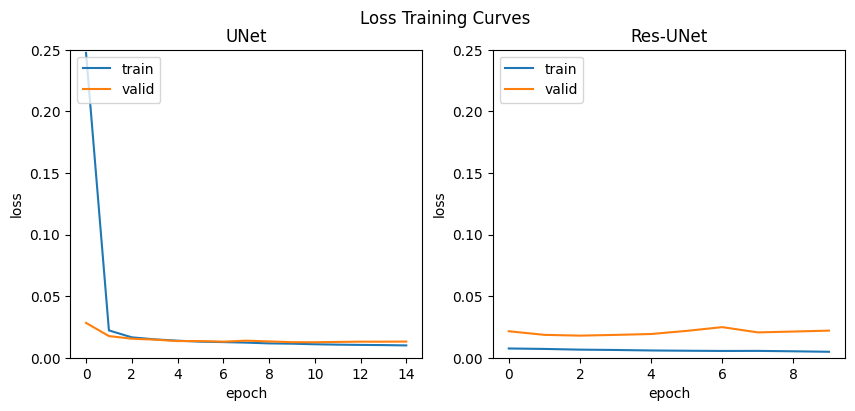

In [120]:
# LOSS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Loss Training Curves')

# UNet loss history
ax1.plot(historyUNet.history['loss'])
ax1.plot(historyUNet.history['val_loss'])
ax1.title.set_text('UNet')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.set_ylim(0, 0.25)
ax1.legend(['train', 'valid'], loc='upper left')

# ResUNet loss history
ax2.plot(historyResUNet.history['loss'])
ax2.plot(historyResUNet.history['val_loss'])
ax2.title.set_text('Res-UNet')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.set_ylim(0, 0.25)
ax2.legend(['train', 'valid'], loc='upper left')

plt.show()

## Predicted Masks

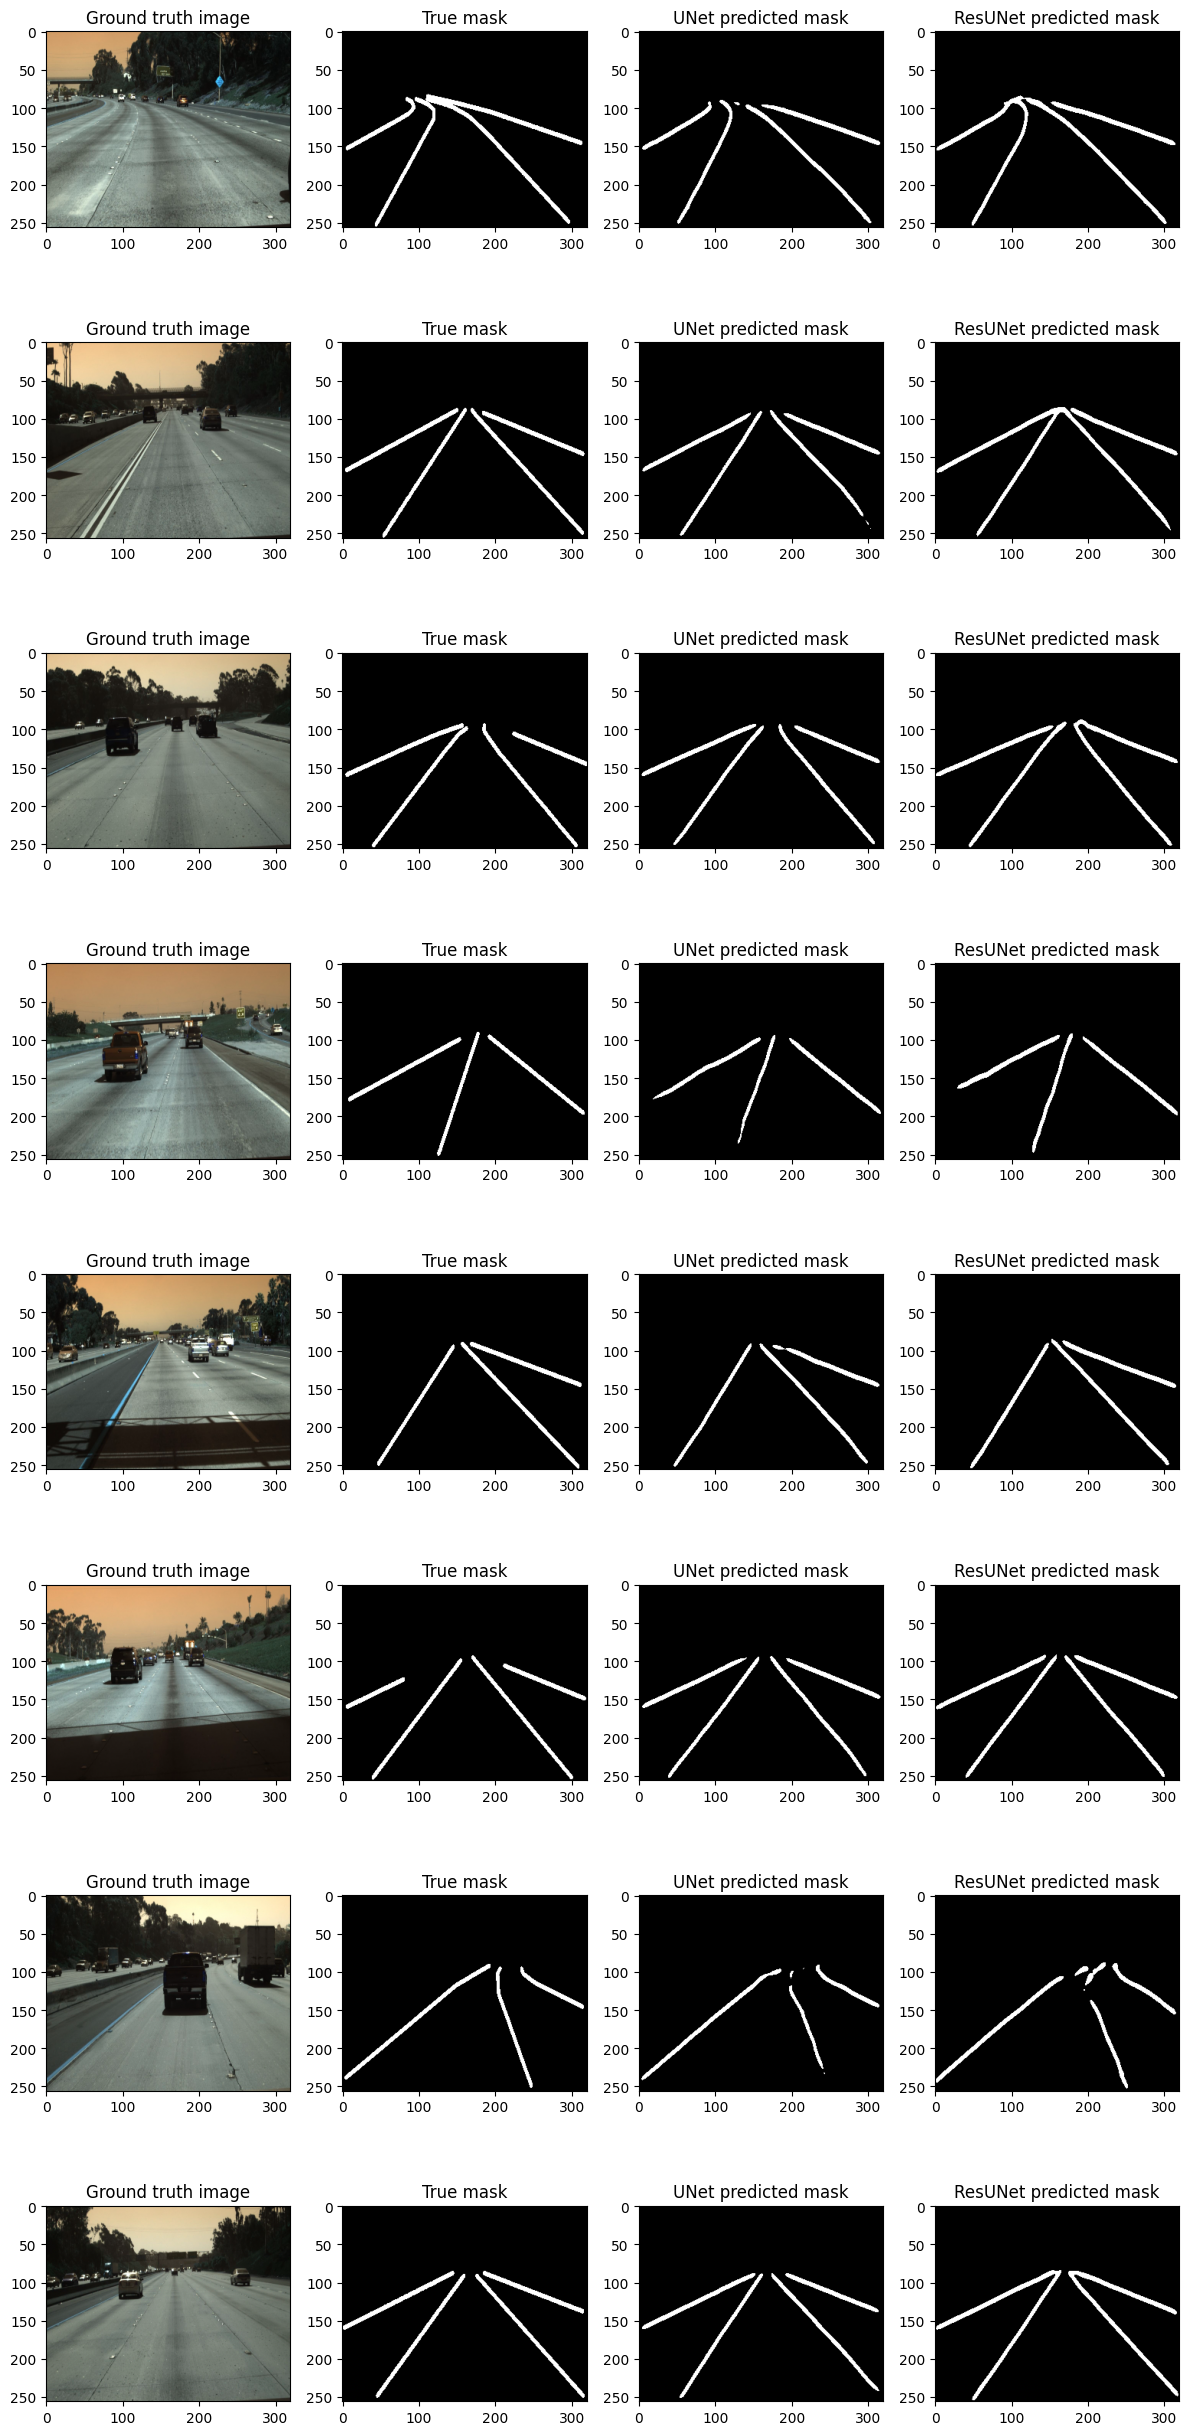

In [ ]:
# Get samples to plot
X_test_samples = X_test[pred_samples[0]:pred_samples[1]]
Y_test_samples = Y_test[pred_samples[0]:pred_samples[1]]

UNet_pred_samples = Y_pred_UNet[pred_samples[0]:pred_samples[1]]
ResUNet_pred_samples = Y_pred_ResUNet[pred_samples[0]:pred_samples[1]]

num_samples = pred_samples[1]-pred_samples[0]

# Display results for both
compare_predictions(X_test_samples, UNet_pred_samples, ResUNet_pred_samples, Y_test_samples, num_plots=num_samples)

## Performance Scores

In [ ]:
# COMPUTE SCORES
labels = [ 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'IoU' ]
print("----- UNet Results -----")
UNet_values = performance_metrics(Y_test, Y_pred_UNet)\

print("\n----- Res-UNet Results -----")
ResUNet_values = performance_metrics(Y_test, Y_pred_ResUNet)

----- UNet Results -----
Accuracy:  0.9786874055862427
Precision: 0.7848350405693054
Recall:    0.7167952656745911
F1 Score:  0.7492736915023758
IoU:       0.5990709066390991

----- Res-UNet Results -----
Accuracy:  0.978340744972229
Precision: 0.7582464814186096
Recall:    0.7523577809333801
F1 Score:  0.7552906533871825
IoU:       0.6068008542060852


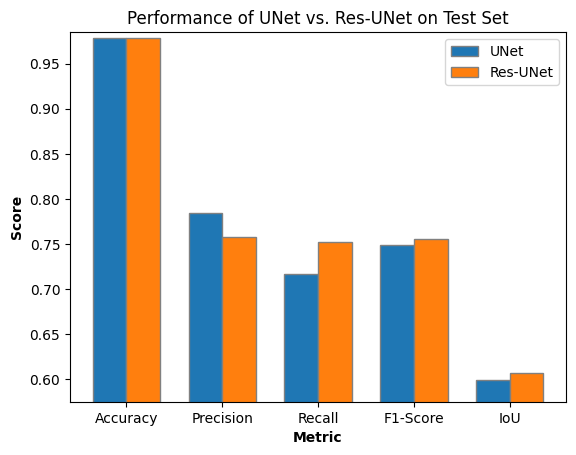

In [ ]:
# PLOTTING
# Bar width
bar_width = 0.35

# Set the position of the bars on the x-axis
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]

# Create bar chart
plt.bar(r1, UNet_values, width=bar_width, edgecolor='grey', label='UNet')
plt.bar(r2, ResUNet_values, width=bar_width, edgecolor='grey', label='Res-UNet')

# Add labels
plt.xlabel('Metric', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.ylim(0.575, 0.985)
plt.xticks([r + bar_width/2 for r in range(len(labels))], labels)
plt.title('Performance of UNet vs. Res-UNet on Test Set')

# Shorten y-ticks
#plt.yticks(np.arange(0.575, max(max(UNet_values), max(ResUNet_values)), 0.025))

# Display
plt.legend()
plt.show()